# Chatbot Training and Usage

By Nazar Mammedov, Date updated: August 22 2024. The original training code is from https://github.com/patrickloeber/chatbot-deployment by Patrick Loeber.

## Prepare the environment
Install the dependencies. You can uncomment and run the installing commands. We install torch and torchvision for machine learning, nltk for natural language processing functionality, matplotlib for plotting charts, and openpyxl for creating JSON file from an Excel file. matplotlib and openpyxl are not required to train the model. But they are useful in the overall setup.

In [61]:
#!pip install torch
#!pip install torchvision 
#!pip install nltk
#!pip install matplotlib #needed if you want to plot your training
#!pip install openpyxl #needed if you want to create intents.json file from an Excel file

Download nltk package dependencies

In [62]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nazar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Prepare libraries

First let's import the libraries we need for our code

In [3]:
import numpy as np
import random
import json
import nltk
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

We also need to import our own code

In [4]:
from nltk_utils import bag_of_words, tokenize, stem
from model import NeuralNet

## Loading data

We load our data from JSON file.

In [5]:
with open('chatbot_intents.json', 'r') as f:
    intents = json.load(f)

# list intents to see
intents

{'intents': [{'tag': 'greeting',
   'proposable': False,
   'patterns': ['Hi', 'Hey'],
   'responses': ['Hello', 'Hi']},
  {'tag': 'goodbye',
   'proposable': False,
   'patterns': ['Bye', 'See you later', 'Goodbye', 'Goodbye'],
   'responses': ['See you later, thanks for visiting',
    'Have a nice day',
    'Bye! Come back again soon.']},
  {'tag': 'thanks',
   'proposable': False,
   'patterns': ['Thank you', 'Thanks'],
   'responses': ["You're welcome! Thanks for visiting!",
    'You are welcome! Thanks for exploring my website!']},
  {'tag': 'originplace',
   'proposable': True,
   'patterns': ['Where are you from?'],
   'responses': ['I am originally from Wakanda and I lived in many different places including Panem, Themyscira, and Pandora.']},
  {'tag': 'currentplace',
   'proposable': True,
   'patterns': ['Where do you live?'],
   'responses': ['I currently live in the Greater Zubrovka area.']},
  {'tag': 'cofee',
   'proposable': False,
   'patterns': ['Do you like coffee?'],

## Creating pairs of patterns and intents
We iterate over the intents list and create a new `xy` list where patterns and intents are paired in a tuple.

In [6]:
all_words = []
tags = []
xy = []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag) # add the tag to its list
    for pattern in intent['patterns']:
        w = tokenize(pattern) # tokenize the pattern
        all_words.extend(w) # add to the words list as items
        xy.append((w, tag))

# let's see what's inside xy now
xy

[(['Hi'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Bye'], 'goodbye'),
 (['See', 'you', 'later'], 'goodbye'),
 (['Goodbye'], 'goodbye'),
 (['Goodbye'], 'goodbye'),
 (['Thank', 'you'], 'thanks'),
 (['Thanks'], 'thanks'),
 (['Where', 'are', 'you', 'from', '?'], 'originplace'),
 (['Where', 'do', 'you', 'live', '?'], 'currentplace'),
 (['Do', 'you', 'like', 'coffee', '?'], 'cofee'),
 (['What', 'kind', 'of', 'food', 'do', 'you', 'like', '?'], 'food'),
 (['What', 'is', 'your', 'favorite', 'car', '?'], 'car')]

## Normalize data
Let's clean the words, convert its case and stem it.

In [7]:
# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

13 patterns
8 tags: ['car', 'cofee', 'currentplace', 'food', 'goodbye', 'greeting', 'originplace', 'thanks']
23 unique stemmed words: ['are', 'bye', 'car', 'coffe', 'do', 'favorit', 'food', 'from', 'goodby', 'hey', 'hi', 'is', 'kind', 'later', 'like', 'live', 'of', 'see', 'thank', 'what', 'where', 'you', 'your']


Now we add the pattern to X variable and tag to Y variable

In [8]:
# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

Content of X and Y. Now everything is a number and the machine is ready to look for the relationships.

In [9]:
X_train

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0.], dtype=float32),


In [10]:
y_train

[5, 5, 4, 4, 4, 4, 7, 7, 6, 2, 1, 3, 0]

We convert everything to a number array now using numpy. This is needed because training will work on numpy arrays.

In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)

## Setting training parameters
We set training hyper parameters here. They don't change during the training process. Number of **epochs** indicates how many times should the machine pass through the data. 
The **batch size** indicates how many pieces of data the training should work on in one batch. An **iteration** is one update of the model’s parameters. The number of iterations per epoch is determined by dividing the total number of training samples by the batch size. For instance, if there are 100 rows and you have a batch size of 5, then you will have 20 iterations per epoch.

The **learning rate** determines the size of the steps the optimizer takes when updating the model’s weights. A higher learning rate means larger steps, while a lower learning rate means smaller steps. If we make it too small, the training can be slow. If it is too big, the training may not be fine enough to find the best weights.

We take input layer's size from the size of the first item in X. The hidden layer size 8 is subjectively chosen. We can experiment with different settings. Output layer size is the number of classes (intents) available. This is calculated from the size of the tags list which contains unique tags.

In [23]:
# Hyper-parameters 
num_epochs = 1800
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

# Use CUDA GPU if available. If not use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the raw model from NeuralNet class with input parameters
model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Set how loss is calculated and the model is optimized
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

23 8


In [20]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

In [21]:
# Train the model
epochs_list = []
loss_list = []
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        epochs_list.append(epoch)
        loss_list.append(loss.item())
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1800], Loss: 1.8339
Epoch [200/1800], Loss: 0.8642
Epoch [300/1800], Loss: 0.4017
Epoch [400/1800], Loss: 0.4978
Epoch [500/1800], Loss: 0.4680
Epoch [600/1800], Loss: 0.0679
Epoch [700/1800], Loss: 0.1583
Epoch [800/1800], Loss: 0.0187
Epoch [900/1800], Loss: 0.0128
Epoch [1000/1800], Loss: 0.0115
Epoch [1100/1800], Loss: 0.0097
Epoch [1200/1800], Loss: 0.0057
Epoch [1300/1800], Loss: 0.0049
Epoch [1400/1800], Loss: 0.0037
Epoch [1500/1800], Loss: 0.0026
Epoch [1600/1800], Loss: 0.0021
Epoch [1700/1800], Loss: 0.0023
Epoch [1800/1800], Loss: 0.0017


## Seeing the relationship between loss and epochs
We can visualizat how the loss decreases with the number of epochs increasing. After a certain epoch_size, the loss rate stops decreasing significantly. 
That's when we know there is no need to run more epochs.

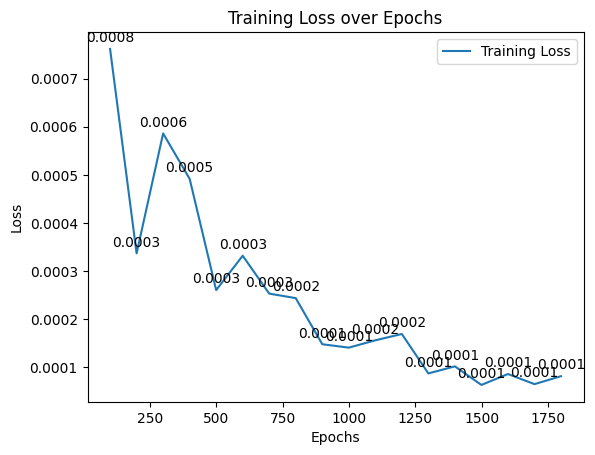

In [40]:
plt.plot(epochs_list, loss_list, label='Training Loss')
for x, y in zip(epochs_list, loss_list):
    plt.annotate(f'{y:.4f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Save trained model to file

In [43]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "chatbot_data.pth"
torch.save(data, FILE)

print(f'Training complete. file saved to {FILE}')

Training complete. file saved to chatbot_data.pth


## Loading and Using the Model
Now we can load the trained model from the file and use it.

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FILE = "chatbot_data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNet(
  (l1): Linear(in_features=23, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
)

Let's see how the model works in practice

In [56]:
question = "Hi"
sentence = tokenize(question)
X = bag_of_words(sentence, all_words)
X = X.reshape(1, X.shape[0])
X = torch.from_numpy(X).to(device)

output = model(X)
print("Output from the model", output)

_, predicted = torch.max(output, dim=1)
print("Prediction", predicted)
print("Predicted item:", predicted.item())

tag = tags[predicted.item()]
print("Predicted tag:", tag)

probs = torch.softmax(output, dim=1)
print("Probabilities:", probs)
print("Probabilities first element:", probs[0])

prob = probs[0][predicted.item()]
print("Probability of predicted item:", prob)

Output from the model tensor([[-0.5336, -6.6284, -6.7773, -1.3415, -0.6749,  9.6294, -6.5134, -9.3251]],
       grad_fn=<AddmmBackward0>)
Prediction tensor([5])
Predicted item: 5
Predicted tag: greeting
Probabilities: tensor([[3.8568e-05, 8.6957e-08, 7.4926e-08, 1.7193e-05, 3.3486e-05, 9.9991e-01,
         9.7553e-08, 5.8633e-09]], grad_fn=<SoftmaxBackward0>)
Probabilities first element: tensor([3.8568e-05, 8.6957e-08, 7.4926e-08, 1.7193e-05, 3.3486e-05, 9.9991e-01,
        9.7553e-08, 5.8633e-09], grad_fn=<SelectBackward0>)
Probability of predicted item: tensor(0.9999, grad_fn=<SelectBackward0>)


We can require an input from the user and get a response from the model. For that first we create a function.

In [63]:
def get_response(msg):
    sentence = tokenize(msg)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                return random.choice(intent['responses'])

    return "Sorry, I didn't understand the question. Could you reformulate please?"

Now we create a console input interface where you can talk to the chatbot.

In [51]:
if __name__ == "__main__":
    print("Let's chat! (type 'quit' to exit)")
    while True:
        # sentence = "do you use credit cards?"
        sentence = input("You: ")
        if sentence == "quit":
            break

        resp = get_response(sentence)
        print(resp)

Let's chat! (type 'quit' to exit)


You:  Hi


Hi


You:  Hello


Sorry, I didn't understand the question. Could you reformulate please?


You:  Hey


Hello


You:  Where do you live


I currently live in the Greater Zubrovka area.


You:  quit
